In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [56]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [86]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [87]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "obso"

In [88]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [89]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from datetime import date
from typing import Optional

class LifeCycle(BaseModel):
    product_name: str = Field(..., description="The name of the product.")
    product_number: str = Field(..., description="Unique identifier for the product")
    description: str = Field(..., description="A brief overview of the product's purpose and features")
    manufacturer: str = Field(..., description="Company producing the item")
    product_family: Optional[str] = Field(None, description="The category the product belongs to")
    release_date: str = Field(..., description="The date when the product was first released (YYYY-MM-DD).")
    mainstream_support_end: str = Field(..., description="The date when mainstream support ends (YYYY-MM-DD).")
    extended_support_end: Optional[str] = Field(None, description="The date when extended support ends, if applicable (YYYY-MM-DD).")
    end_of_support: str = Field(..., description="The final date when all support ends (YYYY-MM-DD).")
    end_of_life: str = Field(..., description="The date when the product reaches the end of its lifecycle (YYYY-MM-DD).")
    is_supported: bool = Field(..., description="Indicates if the product is currently supported.")
    replacement_product: Optional[str] = Field(None, description="Suggested replacement product after EOL.")
    data_fiability: int = Field(None, description="Estimated reliability of the lifecycle data (0-100).")
    price: Optional[float] = Field(None, description="List of prices for the product.")


class ProductDetails(BaseModel):
    product_name: str = Field(..., description="The official name of the product")
    product_number: str = Field(..., description="Unique identifier for the product")
    description: str = Field(..., description="A brief overview of the product's purpose and features")
    manufacturer: str = Field(..., description="Company producing the item")
    product_family: Optional[str] = Field(None, description="The category the product belongs to")
    datasheet_url: Optional[str] = Field(None, description="URL to the product datasheet")
    # Technical specifications
    power_requirements: Optional[str] = Field(None, description="Voltage, current, power consumption, etc.")
    dimensions: Optional[str] = Field(None, description="Size of the product")
    weight: Optional[str] = Field(None, description="Product weight")
    operating_temperature: Optional[str] = Field(None, description="Operating temperature range")
    humidity_range: Optional[str] = Field(None, description="Humidity tolerance")
    ip_rating: Optional[str] = Field(None, description="Ingress Protection (IP) rating")
    performance_metrics: Optional[str] = Field(None, description="Speed, capacity, and other performance data")
    certifications: Optional[str] = Field(None, description="Compliance with standards like CE, RoHS, UL")
    interfaces: Optional[str] = Field(None, description="Available communication interfaces, e.g., Ethernet, RS-485")
    compatibility: Optional[str] = Field(None, description="Compatible devices and software")
    mtbf: Optional[str] = Field(None, description="Mean Time Between Failures (MTBF)")


class SearchProductState(TypedDict):
    lifecycle : LifeCycle # Number of analysts
    search_docs : str # List of documents


In [102]:

question_instructions = """
You are an expert in product lifecycle analysis. Your goal is to extract and analyze the lifecycle details of the provided product based on the given search context.

**Instructions:**
1. **Identify Product Lifecycle Phases:** 
   - Determine the key lifecycle stages such as **release date, mainstream support end, extended support end, end of support, and end of life.**  
   - If a specific detail is not found, respond with `Unknown`.

2. **Data Reliability Assessment:**  
   - Rate the reliability of the extracted information on a scale of **0 to 100**, where:  
     - **100** = Fully confident (official sources, multiple confirmations).  
     - **50-99** = Somewhat confident (mention of dates but lacks official confirmation).  
     - **0-49** = Low confidence (vague or speculative information).  
   - If data reliability cannot be determined, respond with `Unknown`.

3. **Standardize Information:**  
   - Use a consistent format for dates: **YYYY-MM-DD**.  
   - Normalize product-related details, ensuring concise and accurate descriptions.

4. **Identify Missing Elements:**  
   - If critical details such as product family, manufacturer, or replacement product are unavailable, explicitly state `Unknown`.

**Context Provided:**  
{product_search}

"""

import os
import pandas as pd
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import ValidationError

# Excel file path
EXCEL_FILE_PATH = "lifecycle_data.xlsx"

def generate_lifecycle(state):
    """Node to generate a lifecycle entry and save to Excel."""
    
    search_docs = state['search_docs']
    system_message = question_instructions.format(product_search=search_docs)
    
    # Assuming llm is an instantiated model object
    structured_llm = llm.with_structured_output(LifeCycle)

    try:
        # Invoke LLM to get structured response
        lifecycle = structured_llm.invoke([
            SystemMessage(content=system_message),
            HumanMessage(content="Find the product details.")
        ])

        # Validate the response using the LifeCycle Pydantic model
        lifecycle_dict = lifecycle.dict()

        # Add to Excel (create if it doesn't exist)
        update_excel_with_lifecycle(lifecycle_dict)

        # Return lifecycle in state
        return {"lifecycle": lifecycle}

    except ValidationError as e:
        print("Error parsing lifecycle response:", e)
        return {"lifecycle": None}

def update_excel_with_lifecycle(lifecycle_data):
    """
    Add lifecycle data to the Excel file, creating the file if it doesn't exist.
    """
    expected_columns = [
        "product_name", "product_number", "description", "manufacturer", "product_family",
        "release_date", "mainstream_support_end", "extended_support_end",
        "end_of_support", "end_of_life", "is_supported",
        "replacement_product", "data_fiability", "price"
    ]

    # Check if the Excel file exists
    if os.path.exists(EXCEL_FILE_PATH):
        df = pd.read_excel(EXCEL_FILE_PATH)
    else:
        df = pd.DataFrame(columns=expected_columns)

    # Ensure consistent columns
    for col in expected_columns:
        if col not in df.columns:
            df[col] = None  # Add missing columns if needed

    # Convert lifecycle data to DataFrame row
    new_row = pd.DataFrame([lifecycle_data])  # Fix applied here

    # Append new data and save to Excel
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_excel(EXCEL_FILE_PATH, index=False)

    print(f"Data added to '{EXCEL_FILE_PATH}' successfully!")


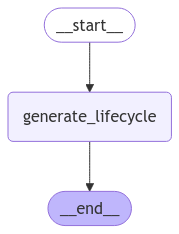

In [103]:


builder = StateGraph(SearchProductState)
builder.add_node("generate_lifecycle", generate_lifecycle)



builder.add_edge(START, "generate_lifecycle")
builder.add_edge("generate_lifecycle", END)



graph = builder.compile( )

# View
display(Image(graph.get_graph(xray=3).draw_mermaid_png()))

In [108]:
from langchain_community.document_loaders import ApifyDatasetLoader
from langchain_core.documents import Document
import json
from apify_client import ApifyClient

# Initialize Apify client
apify_client = ApifyClient('apify_api_nIWu4npaz68DtERdWLn8F2MSOWBDD449co26')

# Function to process each dataset item correctly and limit to the first 10 results
def process_item(dataset_item):
    organic_results = dataset_item.get("organicResults", [])

    # If no organic results exist, return an empty document with appropriate metadata
    if not organic_results:
        return Document(
            page_content="No organic results available.",
            metadata={
                "source": json.dumps(dataset_item.get("searchQuery", "Unknown"))
            }
        )

    # Limit to first 10 results and format content
    grouped_content = "\n\n".join(
        [
            f"Website Title : {result.get('title', 'No title')}\n"
            f"Description: {result.get('description', 'No description')}\n"
            f"Price: {result.get('productInfo', {}).get('price', 'No price')}\n"
            f"URL: {result.get('url', 'No URL')}"
            for result in organic_results[:5]
        ]
    )

    # Create a single grouped document for each dataset row
    return Document(
        page_content=grouped_content,
        metadata={
            "source": json.dumps(dataset_item.get("searchQuery", "Unknown"))  # Convert metadata to JSON string
        }
    )

# Load dataset with correct mapping function
loader = ApifyDatasetLoader(
    dataset_id="7ADmhIeCS0AXnFL5E",
    dataset_mapping_function=process_item
)

# Process each row separately and group documents
grouped_documents = loader.load()

# Display the grouped content for each row
for idx, doc in enumerate(grouped_documents):
    print(f"\n=== Row {idx + 1} (Grouped Documents) ===\n")
    print(doc.page_content)
    print("Metadata:", doc.metadata)
    print("-" * 80)

    # Run the graph until the first interruption
    for event in graph.stream({"search_docs":doc.page_content}, stream_mode="values"):
        # Review
        print(event)




=== Row 1 (Grouped Documents) ===

Website Title : 1492-SP3C040 | US
Description: Lifecycle status: Discontinued ; Discontinued Date: April 30, 2014 ; Replacement Product: 1492-SPM3C040 ...
Price: No price
URL: https://www.rockwellautomation.com/en-us/products/details.1492-SP3C040.html

Website Title : Product Lifecycle Status
Description: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.
Price: No price
URL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html

Website Title : Essential Components
Description: ... N .......................1-12. 140M-RC ... 1492 ..............................................4-13. 1492-FB .......................................2-45. 1492 ...
Price: No price
URL: https://www.teknihaus.com/assets/images/pdf/Allen%20Bradley/20F1ANC170JA0NNNNN/Datasheet/20F1ANC170JA0NNNNN_Allen%20Bradley_PowerFlex%2075_Datashee

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='1492-SP3C040', product_number='1492-SP3C040', description='A product that has been discontinued as of April 30, 2014.', manufacturer='Rockwell Automation', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product='1492-SPM3C040', data_fiability=100, price=None), 'search_docs': 'Website Title : 1492-SP3C040 | US\nDescription: Lifecycle status: Discontinued ; Discontinued Date: April 30, 2014 ; Replacement Product: 1492-SPM3C040\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP3C040.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwe

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MSK030C-0900-NN-M1-UG1-NNNN', product_number='MSK030C-0900-NN-M1-UG1-NNNN', description='A best-in-class synchronous servomotor with a maximum speed of 9,000 rpm, standstill torque of 0.4 Nm, and maximum torque of 1.8 Nm.', manufacturer='Bosch Rexroth Indramat', product_family='MSK Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=478.0), 'search_docs': 'Website Title : MSK030C-0900-NN-M1-UG1-NNNN - Hyperdyne - Rexroth-US\nDescription: Rexroth MSK030C-0900-NN-M1-UG1-NNNN motors have a maximum speed of 9,000 rpm, a standstill torque of 0.4 Nm, and a maximum torque of 1.8 Nm. Very few servos can\xa0...\nPrice: No price\nURL: https://rexroth-us.com/motor/msk-motors/msk030/msk030c-0900-nn-m1-ug1-nnnn/\n\nWebsite Title : MSK030C-0900-NN-M1-UG1-

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='1492-SP2D080', product_number='1492-SP2D080', description='A product that has been discontinued and is suggested to be replaced by a functional replacement.', manufacturer='Rockwell Automation', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product='Functional Replacement', data_fiability=75, price=None), 'search_docs': 'Website Title : 1492-SP2D080 | US\nDescription: Customers are encouraged to remove references to the affected product(s). Discontinued Date: April 30, 2014 Replacement Category: Functional Replacement\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP2D080.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Residual Circuit Devices', product_number='1492-RCD', description='Residual Circuit Devices used for circuit protection.', manufacturer='Allen Bradley', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-05-31', end_of_life='2014-05-31', is_supported=False, replacement_product='Unknown', data_fiability=80, price=None), 'search_docs': 'Website Title : Obsolescence, Replacement, Conversion and Migration for ...\nDescription: As of May 31, 2014, the 1492-RCD Residual Circuit Devices were discontinued and no longer available for sale due to enhanced product features and accessories.\nPrice: No price\nURL: https://rockwellautomation.custhelp.com/app/answers/answer_view/a_id/889898/~/obsolescence%2C-replacement%2C-conversion-and-migration-for-1492-rcd-residual\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catal

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='POWER-LINE FILTER', product_number='R911266399', description='The NFE02.1-230-008 Mains Filter from Rexroth Indramat Bosch provides reduction in low-frequency disturbing signals in the mains line.', manufacturer='Bosch Rexroth', product_family='NFE Mains Filters', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : POWER LINE FILTER | R911266399 | Bosch Rexroth\nDescription: POWER-LINE FILTER NFE02.1-230-008 · Available for Purchase. · Typically ships in 2 business days from Lohr, DE · Estimated transport time: 5 days.\nPrice: No price\nURL: https://store.boschrexroth.com/POWER-LINE-FILTER_R911266399?cclcl=en_XK\n\nWebsite Title : Bosch / Rexroth / Indramat DKC Series Manual\nDescription: 3000 min-1) the nominal

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='On/Off Switch', product_number='194L-E25-1753-6G', description='Number of poles, 3. Rated permanent current Iu, 25 A. Model, On/Off switch. Type of control element, Door coupling rotary drive.', manufacturer='Rockwell Automation', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : 194L-E25-1753-6G | US\nDescription: Number of poles, 3. Rated permanent current Iu, 25 A. Model, On/Off switch. Type of control element, Door coupling rotary drive.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.194L-E25-1753-6G.html\n\nWebsite Title : Essential Components\nDescription: ... 194L ........................................... 1-104. 20A ... date features and informati

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='IndraDrive Cs Compact Converter', product_number='HCS01.1E-W0006-A-02-B-ET-EC-NN-NN-NN-FW', description='The IndraDrive Cs compact converters combine power and control units in a single unit, offering Ethernet-based communication, a multi-encoder interface, and integrated safety technology. They cover the lower kW range of the power range.', manufacturer='Bosch Rexroth', product_family='IndraDrive Cs', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=1981.53), 'search_docs': 'Website Title : compact converter hcs01.1e-w0006-a-02-b-et-ec-nn-l4-nn-fw\nDescription: They combine power and control units in a single unit, and offer Ethernet-based communication, a multi-encoder interface, and integrated safety technology. The IndraDrive Cs (HCS01) compac

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='IndraDrive Cs Compact Converter', product_number='R911331605', description='The IndraDrive Cs (HCS01) compact converters combine power and control units in a single unit, offering Ethernet-based communication, a multi-encoder interface, and integrated safety technology. They cover the lower kW range of the power range.', manufacturer='Bosch Rexroth', product_family='IndraDrive', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : COMPACT CONVERTER | R911331605 - Rexroth Store\nDescription: They combine power and control units in a single unit, and offer Ethernet-based communication, a multi-encoder interface, and integrated safety technology. The IndraDrive Cs (HCS01) compact converters cover the lower kW range 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 10 (Grouped Documents) ===

Website Title : CPE10-M1BH-3GL-QS-6 - Air solenoid valve
Description: Are you looking for more information about Air solenoid valve CPE10-M1BH-3GL-QS-6? Order online now easily from Festo!
Price: No price
URL: https://www.festo.com/us/en/a/196847/

Website Title : Solenoid valve CPE10-M1BH-3GLS-QS-6
Description: Duty cycle. 100% in conjunction with holding current reduction. Max. positive test pulse with 0 signal. 1200 µs. Dec 4, 2024 – Subject to change - Festo SE & Co ...
Price: No price
URL: https://ftp.

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='CPE10-M1BH-3GLS-QS-6 Solenoid Valve', product_number='196850', description='3/2-way Normally Closed (NC) electrically-actuated solenoid pneumatic piloted control valve with non-detenting manual override and internal pilot.', manufacturer='Festo', product_family='Pneumatic Valves', release_date='2023-02-02', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=186.54), 'search_docs': "Website Title : CPE10-M1BH-3GL-QS-6 - Air solenoid valve\nDescription: Are you looking for more information about Air solenoid valve CPE10-M1BH-3GL-QS-6? Order online now easily from Festo!\nPrice: No price\nURL: https://www.festo.com/us/en/a/196847/\n\nWebsite Title : Solenoid valve CPE10-M1BH-3GLS-QS-6\nDescription: Duty cycle. 100% in conjunction with holding current reduction. Max. positive 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Molded Case Circuit Breaker', product_number='1492-SP1B100', description='A circuit breaker used for protecting electrical circuits from overload or short circuit.', manufacturer='Allen-Bradley', product_family='Circuit Breakers', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product='Functional Replacement', data_fiability=75, price=None), 'search_docs': 'Website Title : 1492-SP1B100 | US\nDescription: Customers are encouraged to remove references to the affected product(s). Discontinued Date: April 30, 2014 Replacement Category: Functional Replacement\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP1B100.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SCXI-1000', product_number='Unknown', description='The SCXI-1000 is a chassis for signal conditioning and data acquisition systems.', manufacturer='National Instruments', product_family='SCXI', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : \nDescription: \nPrice: No price\nURL: No URL\n\nWebsite Title : Obsolescence Management - EOL Electronics\nDescription: Find out how EOL fore

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MCB - Supplementary Protector', product_number='1492-SP1C130-N', description='A supplementary protector used in electrical systems, designed to provide additional protection.', manufacturer='Rockwell Automation', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product=None, data_fiability=80, price=None), 'search_docs': "Website Title : 1492-SP1C130-N | US\nDescription: Catalog #: 1492-SP1C130-N. Lifecycle status: Discontinued. Errors. Rockwell Automation announces that as of April 30, 2014, the MCB - Supplementary Protector\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP1C130-N.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lif

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SCXI-1000', product_number='Unknown', description='The SCXI-1000 is a chassis for signal conditioning and data acquisition systems.', manufacturer='National Instruments', product_family='SCXI', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : How do I get product life cycle data for my products?\nDescription: Search for the product page, it should say the life cycle status. For exam

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='FHA-C Mini Series', product_number='Unknown', description='The FHA-C Mini Series is a family of extremely compact Hollow Shaft Servo Actuators that deliver high torque with exceptional accuracy and repeatability.', manufacturer='Harmonic Drive', product_family='Servo Actuators', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : FHA-Mini Compact Hollow Shaft Servo Actuator\nDescription: The FHA-C Mini Series is a family of extremely compact Hollow Shaft Servo Actuators that deliver high torque with exceptional accuracy and repeatability.\nPrice: No price\nURL: https://www.harmonicdrive.net/products/rotary-actuators/actuators-hollow-shaft/fha-mini\n\nWebsite Title : AC Servo Actuators FHA-C Mini Engineering Data

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MSK030C-0900-NN-M1-UG0-NNNN', product_number='MSK030C-0900-NN-M1-UG0-NNNN', description='High torque density motor designed to run for decades without maintenance or repair.', manufacturer='Rexroth', product_family='MSK Motors', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : MSK030C-0900-NN-M1-UG0-NNNN - Hyperdyne - Rexroth-US\nDescription: These high torque density motors often run for decades without the need for maintenance or repair. However, if your MSK030C-0900-NN-M1-UG0-NNNN motor fails, you\xa0...\nPrice: No price\nURL: https://rexroth-us.com/motor/msk-motors/msk030/msk030c-0900-nn-m1-ug0-nnnn/\n\nWebsite Title : MSK030C-0900-NN-M1-UP0-NNNN - Hyperdyne - Rexroth-US\nDescription: MSK motors can run f

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Circuit Breaker', product_number='1492-SP1C040-N', description='Miniature Circuit Breaker', manufacturer='Allen Bradley', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product=None, data_fiability=80, price=None), 'search_docs': 'Website Title : 1492-SP1C040-N | US\nDescription: Catalog #: 1492-SP1C040-N. Lifecycle status: Discontinued. Errors. Rockwell Automation announces that as of April 30, 2014, the MCB - Supplementary Protector 4\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP1C040-N.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: http

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MCB - Supplementary Protector', product_number='1492-SP1C060-N', description='A single pole overcurrent fuse with maximum isolation current of 6A.', manufacturer='Rockwell Automation', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2014-04-30', end_of_life='2014-04-30', is_supported=False, replacement_product='Functional Replacement', data_fiability=100, price=None), 'search_docs': 'Website Title : 1492-SP1C060-N | US\nDescription: Catalog #: 1492-SP1C060-N. Lifecycle status: Discontinued. Errors. Rockwell Automation announces that as of April 30, 2014, the MCB - Supplementary Protector 6\xa0...\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.1492-SP1C060-N.html\n\nWebsite Title : 1492-SP1C060 | US\nDescription: Customers are encouraged to remove references to the affected product(s). Disconti

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='CT-E Time Relays', product_number='Unknown', description='Time relays used for various timing applications.', manufacturer='ABB', product_family='Time Relays', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2023-12-31', end_of_life='2023-12-31', is_supported=False, replacement_product='CT-C Time Relay Range', data_fiability=80, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Lifecycle\nDescription: All support services for the product become unavailable after this date, and the product becomes obsolete. This is also

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='LOCC-Box ES 7-6425', product_number='716425', description='LUTZE LOCC-Box provides reliable load monitoring and protection in 24V DC control circuits. Innovative features include adjustable trip current range (1-10A).', manufacturer='Lutze', product_family='LOCC-Box', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : LOCC-Box LUTZE Overload Current Control\nDescription: We realise this by using components for highly efficient control systems, products with above average life cycles ... LOCC Box ES 7-6425. 1. Supply kit (supply\xa0...\nPrice: No price\nURL: https://www.lutze.com/fileadmin/luetze.com/media/en-us/catalog/M320816-lutze-locc-box-lutze-inc.pdf\n\nWebsite Title : LOCC-Box supply set\nDescription: LOC

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Brocade', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Brocade Product End-of-Life\nDescription: Once you have received an End-of-Life (EOL) notification from Brocade, you can continue to purchase the product until the Last Time Order date,\xa0...\nPrice: No price\nURL: https://www.broadcom.com/support/fibre-channel-networking/eol\n\nWebsite Title : Summary Technical Report of Division 16, NDRC ... - DTIC\nDescription: This volume is classified RESTRICTED in accordance with security regu- lations of the War and Navy Departments because certain chapters contain.\nPrice: No price\nURL: https://apps.dtic.mil/sti/tr

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='DSI Software', product_number='Unknown', description='Software support lifecycle management by Data Sciences International.', manufacturer='Data Sciences International', product_family='Unknown', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Forecasting and Proactive Management of Obsolescence for ...\nDescription: by P Sandborn · Cited by 3 — This paper describes a new methodology for forecasting electronic part obsolescence using a combination of life cycle curve forecasting and the determination of\xa0...\nPrice: No price\nURL: http://escml.umd.edu/ObsSGER/2006GranteesConf.pdf\n\nWebsite Title : Design for Obsolescence Risk Management\nDescription: by P Sandborn · 2013 · Cited by 94 — Strategic managem

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Load Switch', product_number='194L-E25-1754-6A', description='A 4-pole On/Off toggle switch with a rated permanent current of 25 A and a rated impulse voltage of 6.', manufacturer='Allen Bradley', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : 194L-E25-1754-6A | US\nDescription: Number of poles, 4. Rated permanent current Iu, 25 A. Model, On/Off switch. Type of control element, Toggle. Rated impulse voltage (Uimp), 6.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/products/details.194L-E25-1754-6A.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='PNOZmulti classic', product_number='Unknown', description='Configurable safety systems designed for various safety applications.', manufacturer='Pilz', product_family='Configurable Safety Systems', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2024-12-31', end_of_life='2024-12-31', is_supported=True, replacement_product='PNOZmulti 2', data_fiability=80, price=None), 'search_docs': 'Website Title : Configurable safety systems PNOZmulti – Base units\nDescription: The configurable safety systems PNOZmulti classic will be discontinued on 31.12.2024. The last order date is 30.09.2024! We recommended the PNOZmulti 2 product\xa0...\nPrice: No price\nURL: https://www.pilz.com/en-US/products/small-controllers/configurable-safety-systems/pnozmulti-controllers\n\nWebsite Title : PNOZmulti Modular Safety System - of /downloads - Pilz\nDescription: We have t

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='USB female insert', product_number='VS-04-BUA-BUB-F/IP67 - 1653838', description='USB female insert with IP67 protection, designed for high durability with over 1000 insertion/withdrawal cycles.', manufacturer='Phoenix Contact', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : VS-04-BUA-BUB-F/IP67 - USB female insert - 1653838\nDescription: Mechanical data. Insertion/withdrawal cycles, ≥ 1000. Environmental and real-life conditions. Ambient conditions. Degree of protection, IP20. Ambient\xa0...\nPrice: No price\nURL: https://www.phoenixcontact.com/en-us/products/female-insert-vs-04-bua-bub-fip67-1653838\n\nWebsite Title : USB female insert - VS-04-BUA-BUB-F/IP67 - 1653838\nDescription: US

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='PNOZ MO4P', product_number='PNOZ MO4P 4N/O', description='Output Module, 4 Out, 24 VDC, 6A, Spring Loaded Screw Term, PNOZ Series', manufacturer='Pilz', product_family='PNOZ Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=1240.93), 'search_docs': 'Website Title : PNOZ mo4p\nDescription: Service life graph for the relay contacts. The service life graphs indicate the number of cycles from which failures due to wear must be expected. The wear\xa0...\nPrice: No price\nURL: https://cdn.logic-control.com/docs/pilz-safety/Manuals/PNOZ_mo4p_Operat_Man_20942-EN-09.pdf\n\nWebsite Title : Pilz - PNOZ MO4P 4N/O - Output Module, 4 Out, 24 VDC ...\nDescription: Pilz PNOZ MO4P 4N/O. Output Module, 4 Out, 24 VDC, 6A, Spring Loaded Screw Term, PNOZ Serie

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='84-8511.9620', description='CONTACT BLOCK SPST-NO 0.1A 42V', manufacturer='EAO', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Switching element | 84-8511.9620\nDescription: Switching element ; Mechanical lifetime: ≥1 Mio. cycles of operation ; Operating force: 4.5 N ±1 N (measured at the lens) ; Operating Travel: ca. 0.5 mm ; Weight:\xa0...\nPrice: No price\nURL: https://eao.com/component/84-8511.9620/en/switching-element\n\nWebsite Title : 84-8511.9620 EAO | Switches\nDescription: Manufacturer Product Number. 84-8511.9620 ; Description. CONTACT BLOCK SPST-NO 0.1A 42V ; Manufacturer Standard Lead Time. 14 Weeks ; Customer Reference.\nPrice: No price

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='QUINT4-PS/1AC/24DC/10', product_number='2904601', description='The QUINT4-PS/1AC/24DC/10 is a power supply unit designed for industrial applications, featuring a life expectancy of 283,000 hours at 40°C and 230 V AC.', manufacturer='Phoenix Contact', product_family='QUINT POWER', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='2022-10-31', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product discontinuation notification (PDN)\nDescription: Effective date (EOP). 2022-10-31. End of Service (EOSR). -. End of Sales (EOS). 2022-10 ... 2938604 QUINT-PS-100-240AC/24DC/10. 22. 22. 2904601 QUINT4-PS/1AC/24DC\xa0...\nPrice: No price\nURL: https://www.farnell.com/datasheets/3672266.pdf\n\nWebsite Title : QUINT-PS/1AC/24DC/10 - Power supply unit - 2866763\nDescription: QUI

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='PNOZmulti classic', product_number='Unknown', description='Configurable safety systems designed to ensure safety in industrial environments.', manufacturer='Pilz', product_family='Configurable Safety Systems', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2024-12-31', end_of_life='2024-12-31', is_supported=True, replacement_product='Unknown', data_fiability=80, price=None), 'search_docs': 'Website Title : Configurable safety systems PNOZmulti – Base units\nDescription: The configurable safety systems PNOZmulti classic will be discontinued on 31.12. 2024. The last order date is 30.09.\nPrice: No price\nURL: https://www.pilz.com/en-INT/products/small-controllers/configurable-safety-systems/pnozmulti-controllers\n\nWebsite Title : PNOZmulti Modular Safety System - of /downloads - Pilz\nDescription: We have taken great care in compiling our applicat

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='IFFM 08P17A6/L', product_number='10142377', description='Inductive proximity switch - subminiature', manufacturer='Baumer', product_family='Inductive Sensors', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : IFFM 08P17A6/L | Inductive proximity switch\nDescription: IFFM 08P17A6/L. Article no.: 10142377. Inductive proximity switch - subminiature. > 10 pieces immediately available from stock.\nPrice: No price\nURL: https://www.baumer.com/us/en/p/24746\n\nWebsite Title : IFFM 08P17A6/L Inductive proximity switch\nDescription: IFFM 08P17A6/L. IFFM 08P17A6/L. Inductive proximity switch. Inductive sensors www.baumer.com general data mounting type flush nominal sensing\xa0...\nPrice: No price\nURL: https://docs.rs-

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='i10-M0233 Lock', product_number='6022580', description='The i10-M0233 Lock is a safety switch with a mechanical life of 1 million switching cycles, an enclosure rating of IP67, and an operating temperature range of -20°C to +55°C.', manufacturer='SICK Germany', product_family='Safety Switches', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : i10-M0233 Lock - SICK Germany\nDescription: Comprehensive services complete our offering: SICK lifetime Services provide support throughout the ma- chine life cycle and ensure safety and productivity.\nPrice: No price\nURL: https://cdn.sick.com/media/pdf/3/93/493/dataSheet_i10-M0233-Lock_6022580_en.pdf\n\nWebsite Title : i10-M0233 Lock\nDescription: Mechanical life, 1 x 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Nessus 10.8.x', product_number='Unknown', description='Nessus is a vulnerability scanner used to identify potential vulnerabilities in systems.', manufacturer='Tenable', product_family='Nessus', release_date='2024-07-01', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='2024-07-31', is_supported=True, replacement_product=None, data_fiability=75, price=None), 'search_docs': 'Website Title : Tenable Software Release Lifecycle Matrix\nDescription: Page 1. Nessus version. GA Date. End of Standard Support. End of Life Achieved/Last Day of Support. Additional Information. 10.8.x. July, 2024.\nPrice: No price\nURL: https://docs.tenable.com/PDFs/product-lifecycle-management/tenable-software-release-lifecycle-matrix.pdf\n\nWebsite Title : Obsolescence and life cycle management for automation ...\nDescription: This recommended practice gives guidance in life 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='61-8755.17', description='Switching element with a rating of 250 V AC/DC @ 5 A, electrical lifetime of 6050 cycles, and electric strength of 4000 VAC, 50 Hz, 1 minute.', manufacturer='EAO', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=25.82), 'search_docs': 'Website Title : Switching element | 61-8755.17\nDescription: Switching rating: 250 V AC/DC @ 5 A ; Electrical lifetime: 6050 cycles of operation according to EN/IEC 60947-5-5 ; Electric strength: 4000 VAC, 50 Hz, 1 minute,\xa0...\nPrice: No price\nURL: https://eao.com/component/61-8755.17/en/switching-element\n\nWebsite Title : 61-8755.17 EAO | Mouser Canada\nDescription: Protection of the HMI system is crucial, making stainless stee

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Main Unit, General-purpose Type, 71 Optical Axes', product_number='SL-V71F', description='KEYENCE supports customers from the selection process to line operations with on-site operating instructions and after-sales support.', manufacturer='KEYENCE', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Main Unit, General-purpose Type, 71 Optical Axes - SL-V71F\nDescription: KEYENCE supports customers from the selection process to line operations with on-site operating instructions and after-sales support.\nPrice: No price\nURL: https://www.keyence.com/products/safety/light-curtain/sl-v/models/sl-v71f/\n\nWebsite Title : United States Government publications monthly catalog, ...\nDescription: W

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 36 (Grouped Documents) ===

Website Title : Product Lifecycle Status
Description: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.
Price: No price
URL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html

Website Title : Product Lifecycle Status
Description: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Veritas 5250 Appliance', product_number='Unknown', description='A hardware appliance used for data protection and management.', manufacturer='Veritas', product_family='Appliances', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end='2029-06-30', end_of_support='2029-06-30', end_of_life='2029-06-30', is_supported=False, replacement_product='Unknown', data_fiability=80, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products a

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='DEK-OV- 24DC/24DC/3/AKT Solid-state relay terminal block', product_number='2964296', description='Power solid-state relay terminal block for actuator, input: 24 V DC, output: 3 - 30 V DC/3 A, terminal block width: 6.2 mm.', manufacturer='Phoenix Contact', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : 24DC/ 3/AKT - Solid-state relay terminal block - 2964296\nDescription: Power solid-state relay terminal block for actuator, input: 24 V DC, output: 3 - 30 V DC/3 A, terminal block width: 6.2 mm. In stock.\nPrice: No price\nURL: https://www.phoenixcontact.com/en-us/products/solid-state-relay-module-dek-ov-24dc-24dc-3akt-2964296\n\nWebsite Title : DEK-OV- 24DC - Solid-state relay terminal bl

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 39 (Grouped Documents) ===

Website Title : Air solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5
Description: Are you looking for more information about Air solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5? Order online now easily from Festo!
Price: No price
URL: https://www.festo.com/us/en/a/570850/

Website Title : Solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5
Description: Are you looking for more information about Solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5? Order online now easily from Festo!
Price: No price
URL: https://www.festo.com

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='VSVA-B-M52-MZD-A1-1T1L-APX-0.5', product_number='570850', description='Festo VSVA-B-M52-MZD-A1-1T1L-APX-0.5 Valve function=5/2 monostable, Type of actuation=electrical, Width=26 mm, Standard nominal flow rate=1100 l/min.', manufacturer='Festo', product_family='Solenoid Valve', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=279.09), 'search_docs': 'Website Title : Air solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5\nDescription: Are you looking for more information about Air solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5? Order online now easily from Festo!\nPrice: No price\nURL: https://www.festo.com/us/en/a/570850/\n\nWebsite Title : Solenoid valve VSVA-B-M52-MZD-A1-1T1L-APX-0.5\nDescription: Are you looking for more information about Solenoid val

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='WatchGuard Technologies', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : End of Life Policy | WatchGuard Technologies\nDescription: Product EOS dates will be up to five years prior to product EOL and all EOL communications will start with an official EOL Intent Announcement at least 60 days\xa0...\nPrice: No price\nURL: https://www.watchguard.com/wgrd-trust-center/end-of-life-policy'}

=== Row 41 (Grouped Documents) ===

Website Title : Solenoid valve VZWD-L-M22C-M-G14-30-V-1P4-15-R1
Description: Are you looking for more information about Solenoid valve VZWD-L-M22C-M-G14-30-V-1P4-15-R1? Order online now easily fro

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Solenoid valve VZWD-L-M22C-M-G14-30-V-1P4-15', product_number='VZWD-L-M22C-M-G14-30-V-1P4-15', description='Directly actuated poppet valve with electrical actuation and soft sealing principle. Mounting position is flexible.', manufacturer='Festo', product_family='VZWD Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=98.88), 'search_docs': 'Website Title : Solenoid valve VZWD-L-M22C-M-G14-30-V-1P4-15-R1\nDescription: Are you looking for more information about Solenoid valve VZWD-L-M22C-M-G14-30-V-1P4-15-R1? Order online now easily from Festo!\nPrice: No price\nURL: https://www.festo.com/tw/en/a/1491860/\n\nWebsite Title : VZWD-L-M22C-M-G14-30-V-1P4-15\nDescription: Type code, VZWD. Design, Directly controlled poppet valve. Actuation type, 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 43 (Grouped Documents) ===

Website Title : Micronel F62MM-9 Series Axial Fan, 24 V dc, DC Operation ...
Description: Extremely low profile fans with polarity protection and reverse mounting capability.
Price: 1004.85
URL: https://twen.rs-online.com/web/p/axial-fans/8180286?srsltid=AfmBOopRR-dyCozAOT1-CNcs_O18Mak0y5w7mYQHx_RVxDF4KKaARmTS
Metadata: {'source': '{"term": "F62MM-024GK-9 life cycle Obsolescence date", "url": "http://www.google.com/search?q=F62MM-024GK-9+life+cycle+Obsolescence+date&num=100", "device": "DESKTOP", "page": 1,

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Micronel F62MM-9 Series Axial Fan', product_number='8180286', description='Extremely low profile fans with polarity protection and reverse mounting capability.', manufacturer='Micronel', product_family='Axial Fans', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=1004.85), 'search_docs': 'Website Title : Micronel F62MM-9 Series Axial Fan, 24 V dc, DC Operation ...\nDescription: Extremely low profile fans with polarity protection and reverse mounting capability.\nPrice: 1004.85\nURL: https://twen.rs-online.com/web/p/axial-fans/8180286?srsltid=AfmBOopRR-dyCozAOT1-CNcs_O18Mak0y5w7mYQHx_RVxDF4KKaARmTS'}

=== Row 44 (Grouped Documents) ===

Website Title : VABS-S4-1S-N14-B-K2 Pneumatic Accessory by FESTO
Description: VABS-S4-1S-N14-B-K2 Pneumatics fro

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Pneumatic Accessory', product_number='VABS-S4-1S-N14-B-K2', description='SUB BASE, FOR VALVE, 15407-2 PORT PATTERN, 26 MM WIDE', manufacturer='FESTO', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : VABS-S4-1S-N14-B-K2 Pneumatic Accessory by FESTO\nDescription: VABS-S4-1S-N14-B-K2 Pneumatics from FESTO In Stock, Order Now! 2-Year Warranty - SUB BASE, FOR VALVE, 15407-2 PORT PATTERN, 26 MM WIDE.\nPrice: No price\nURL: https://www.radwell.co.uk/Buy/FESTO/FESTO/VABS-S4-1S-N14-B-K2?parentitemid=10053403\n\nWebsite Title : Sub-base VABS-S4-1S-G14-B-R3\nDescription: Feature. Value. Construction width. 26 mm. Based on standard. ISO 15407-2. Mounting position optional. Pilot air supply. Internal

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='VS-08-BU-RJ45/BU', product_number='1689064', description='RJ45 coupling, degree of protection: IP20, number of positions: 8, 1 Gbps, CAT5, material: Plastic, connection method: Coupling, Keystone, Ethernet.', manufacturer='Phoenix Contact', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : VS-08-BU-RJ45/BU - RJ45 coupling - 1689064\nDescription: RJ45 coupling, degree of protection: IP20, number of positions: 8, 1 Gbps, CAT5, material: Plastic, connection method: Coupling, Keystone, Ethernet.\nPrice: No price\nURL: https://www.phoenixcontact.com/en-us/products/female-insert-vs-08-bu-rj45bu-1689064\n\nWebsite Title : End-of-Life and End-of-Sale Notices\nDescription: End-of-Sale and End-of-Li

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='DVDR990', product_number='DVDR990 /001 /021', description='DVD-Video Recorder', manufacturer='Philips', product_family='DVD Recorder', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : 0000950123-10-026616.txt\nDescription: ... DATE: 20100322 DATE AS OF CHANGE: 20100322 FILER: COMPANY DATA: COMPANY CONFORMED NAME: NATIONAL FUEL GAS CO CENTRAL INDEX KEY: 0000070145 STANDARD\xa0...\nPrice: No price\nURL: https://www.sec.gov/Archives/edgar/data/70145/000095012310026616/0000950123-10-026616.txt\n\nWebsite Title : 0001157523-16-006840.txt\nDescription: ... DATE: 20161006 DATE AS OF CHANGE: 20161006 FILER: COMPANY DATA: COMPANY CONFORMED NAME: CURTISS WRIGHT CORP CENTRAL INDEX KEY: 0000026324 STANDARD\xa0...\nPrice

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Solenoid valve CPE10-M1BH-5/3G-QS4-B', product_number='533147', description='A solenoid valve with a 5/3 closed valve function, electrically actuated, with a construction width of 10 mm and a standard nominal flow rate of 180 l/min.', manufacturer='Festo SE & Co. KG', product_family='Solenoid Valve', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Solenoid valve CPE10-M1BH-5/3G-QS4-B\nDescription: Feature. Value. Valve function. 5/3 closed. Type of actuation. Electric. Construction width. 10 mm. Standard nominal ow rate (standardised to DIN 1343).\nPrice: No price\nURL: https://ftp.festo.com/public/PNEUMATIC/SOFTWARE_SERVICE/DataSheet/EN_GB/533147.pdf\n\nWebsite Title : Solenoid valve CPE10-M1BH-5/3GS-QS4-B\

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 49 (Grouped Documents) ===

Website Title : Product Lifecycle Status
Description: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.
Price: No price
URL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html

Website Title : Obsolescence Management - EOL Electronics
Description: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools availabl

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence Management - EOL Electronics\nDescription: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools available to support your lifecycle planning.\nPrice: No price\nURL: ht

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : OPT-C2514-5M - Industrial Lenses\nDescription: Compatible with 5MP industrial cameras [1] which pixel size ≥ 3.45 μm and max. 2/3" sensor; resolution up to 140 lp/mm in full FOV.\nPrice: No price\nURL: https://www.optmv.net/content/details75_983.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-life

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 52 (Grouped Documents) ===

Website Title : AVT Manta G-504 B/C GigE camera
Description: The Manta G-504 camera has been discontinued by Allied Vision. Orders can be placed for these models no later than August 31, 2024.
Price: No price
URL: https://www.1stvision.com/cameras/models/Allied-Vision/Manta%20G-504%20B/C

Website Title : Manta User Guide V8.2.7
Description: Manta G-504 series. The following table provides model series specifications. The values are valid for. Manta G-504B and G-504C models. For ...
Price: No price
URL: http

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Manta G-504', product_number='G-504B/C', description='The Manta G-504 is a machine vision camera that incorporates the high quality Type 2/3 (11.016 mm diagonal) Sony ICX655 CCD sensor, running at 9.2 frames per second at 5.0 MP resolution.', manufacturer='Allied Vision', product_family='Manta', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2024-08-31', end_of_life='2024-08-31', is_supported=True, replacement_product=None, data_fiability=75, price=None), 'search_docs': "Website Title : AVT Manta G-504 B/C GigE camera\nDescription: The Manta G-504 camera has been discontinued by Allied Vision. Orders can be placed for these models no later than August 31, 2024.\nPrice: No price\nURL: https://www.1stvision.com/cameras/models/Allied-Vision/Manta%20G-504%20B/C\n\nWebsite Title : Manta User Guide V8.2.7\nDescription: Manta G-504 series. The following

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 54 (Grouped Documents) ===

Website Title : Obsolescence Management - EOL Electronics
Description: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools available to support your lifecycle planning.
Price: No price
URL: https://www.siliconexpert.com/manage-obsolescence/

Website Title : Obsolescence and life cycle management for automation ...
Description: This report defines the proactive Obsolescence Management Process as it applies to automation systems for oil and gas producers a

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SCXI-1000', product_number='Unknown', description='The SCXI-1000 is a chassis used for signal conditioning in data acquisition systems.', manufacturer='National Instruments', product_family='SCXI', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Obsolescence Management - EOL Electronics\nDescription: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools available to support your lifecycle planning.\nPrice: No price\nURL: https://www.siliconexpert.com/manage-obsolescence/\n\nWebsite Title : Obsolescence and life cycle management for automation ...\nDescription: This report defines the proactive Obsolescence Management Process as it applies to automation sys

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MZT8-03VPS-KUB', product_number='1044470', description='Cylinder sensors: MZT8. MZT8-03VPS-KUB is a sensor for T-slot cylinders.', manufacturer='SICK', product_family='Magnetic Cylinder Sensors', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : MZT8-03VPS-KUB\nDescription: Comprehensive services complete our offering: SICK lifetime Services provide support throughout the ma- chine life cycle and ensure safety and productivity.\nPrice: No price\nURL: https://www.sick.com/media/pdf/4/54/654/dataSheet_MZT8-03VPS-KUB_1044470_en.pdf\n\nWebsite Title : MZT8-03VPS-KUB\nDescription: Cylinder sensors: MZT8. MZT8-03VPS-KUB. Part no.: 1044470. Log in to get your price and the estimated date of arrival. pc. pc. Add to ca

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='EK1100', product_number='Unknown', description='The EK1100 EtherCAT Coupler is the link between the EtherCAT protocol at fieldbus level and the EtherCAT Terminals.', manufacturer='Beckhoff', product_family='EtherCAT Coupler', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2022-11-24', end_of_life='2022-11-24', is_supported=False, replacement_product=None, data_fiability=80, price=None), 'search_docs': 'Website Title : Manual | EN - Automation Interface - download - Beckhoff\nDescription: This description is only intended for the use of trained specialists in control and automation engineering who are familiar with applicable national\xa0...\nPrice: No price\nURL: https://download.beckhoff.com/download/document/automation/twincat2/TwinCAT_2_AUTOMATION_INTERFACE_EN.pdf\n\nWebsite Title : EK1100 | EtherCAT Coupler\nDescription: The EK1100 EtherCAT C

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='EL6695', product_number='Unknown', description='EtherCAT Bridge Terminal for real-time data exchange between EtherCAT strands with different masters.', manufacturer='Beckhoff', product_family='EtherCAT Terminals', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : EL6695 - EtherCAT Bridge Terminal - download - Beckhoff\nDescription: process data for the most recent cycle. C. For every EtherCAT Slave that has cyclic process data, the Master displays, using what is known as\xa0...\nPrice: No price\nURL: https://download.beckhoff.com/download/Document/io/ethercat-terminals/el6695_en.pdf\n\nWebsite Title : EL6692 | EtherCAT Terminal, communication interface ...\nDescription: The EtherCAT bridge terminal EL6692 enab

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='GARDASOFT LFC 420', product_number='Unknown', description='Programmable LED lighting controller with 2 or 4 independent channels providing standard or fast timing, high overdrive current up to 10 A.', manufacturer='Gardasoft', product_family='Unknown', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product end of life policy 4th May 2021\nDescription: Gardasoft will issue a written end-of-life notice a minimum of 6 months before production of any product is ended. Final orders must be received\xa0...\nPrice: No price\nURL: http://www.gardasoft.com/support/end-of-life-policy/\n\nWebsite Title : GARDASOFT LFC 420\nDescription: Programmable LED lighting controller with 2 or 4 independent channels providing sta

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Cisco ASR1000 Embedded Services Processor', product_number='Unknown', description='Cisco ASR1000 Embedded Services Processor is part of the Cisco ASR 1000 Series Aggregation Services Routers, designed to provide high-performance routing and network services.', manufacturer='Cisco', product_family='ASR 1000 Series Aggregation Services Routers', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : End-of-Sale and End-of-Life Announcement for the ...\nDescription: Cisco announces the end-of-sale and end-of-life dates for the Cisco Select Cisco ASR1000 Embedded Services Processor.\nPrice: No price\nURL: https://www.cisco.com/c/en/us/products/collateral/routers/asr-1000-series-aggregation-services-routers/eos-eol-not

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence and life cycle management for automation ...\nDescription: This recommended practice gives guidance in life cycle planning and obsolescence management to maintain integrity, high availability and low life cycle cost\xa0.

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Cat 5e Cable', product_number='Unknown', description='Ethernet cable used for networking, capable of supporting up to 1 Gbps speeds over short distances.', manufacturer='Unknown', product_family='Networking Cables', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : Cat 5 & Cat 5e Cable Life Expectancy : r/sysadmin\nDescription: Sources on google state the life of these cables is between 10 and 25 years but I can't get any concrete answers.\nPrice: No price\nURL: https://www.reddit.com/r/sysadmin/comments/j62jp8/cat_5_cat_5e_cable_life_expectancy/\n\nWebsite Title : CAT5e Cables Shelf Life? - Networking\nDescription: I know of no “shelf life” on unused cables. I personally buy bulk cable and terminate myself fo

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='CS-STAN Issue 4', product_number='Unknown', description='CS-STAN Issue 4 provides standards for the certification of small aircraft modifications and repairs.', manufacturer='European Union Aviation Safety Agency (EASA)', product_family='Aviation Standards', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : air force instruction 21-101 - AF.mil\nDescription: This publication implements Air Force Policy Directive (AFPD) 21-1, Maintenance of Military. Materiel. It is the basic Air Force Instruction\xa0...\nPrice: No price\nURL: https://static.e-publishing.af.mil/production/1/jbmcguire-dix-lakehurst/publication/afi21-101_amcsup_jbmdlsup/afi21-101_amcsup_jbmdlsup.pdf\n\nWebsite Title : Uniform Standard Specificati

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='TH-140X105SW', product_number='366', description='This Light Unit emits white light and is a discontinued product.', manufacturer='CCS', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2018-05-31', end_of_life='2018-05-31', is_supported=False, replacement_product='TH2-140X105SW', data_fiability=80, price=None), 'search_docs': 'Website Title : TH-140X105SW\nDescription: TH-140X105SW. Discontinued Product. Not available from May/31/2018". The recommended alternative model is TH2-140X105SW. This Light Unit emits white light\xa0...\nPrice: No price\nURL: https://www.ccs-grp.com/products/model/366\n\nWebsite Title : World\'s highest standards of LED Lighting Technology Let ...\nDescription: CCS will provide the optimum Red Lights for your site environment. Quality improved with the use of long-life four-element LEDs. The slower deg

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Cisco MDS 9132T', product_number='Unknown', description='Cisco MDS 9132T is a multilayer fabric switch designed for storage networking.', manufacturer='Cisco', product_family='MDS 9100 Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2024-10-03', end_of_life='2024-10-03', is_supported=False, replacement_product=None, data_fiability=80, price=None), 'search_docs': 'Website Title : End-of-Life and End-of-Sale Notices\nDescription: End-of-Sale and End-of-Life Announcement for the Cisco MDS 9132T Bundles With Traditional Software Licenses 03/Oct/2024; End-of-Sale and End-of-Life\xa0...\nPrice: No price\nURL: https://www.cisco.com/c/en/us/products/storage-networking/mds-9100-series-multilayer-fabric-switches/eos-eol-notice-listing.html\n\nWebsite Title : FlashSystem 9100 (9848-A9F)\nDescription: FlashSystem 9100 (9848-A9F) Machine Type Model: 9

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Life Cycle\nDescription: The EOL date should be read as "last-time-buy is expected to be in the middle of the specified year". Products are not discontinued arbitrarily after 8 years.\xa0...\nPrice: No price\nURL: https://www.compulab.com/support/life-cycle/\n\nWebsite Title : Product Lifecycle\nDescription: All support services for the product become unavailable after this date, and the product becomes obsolete. This is also known as End of Life (EOL). +5 years\xa0...\nPrice: No price\nURL: https://www.cambiumnetworks.com/support/product-lifecycle/\n

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='84-8511.9620', description='CONTACT BLOCK SPST-NO 0.1A 42V, designed for use with pushbutton switches, part of the 84 Series.', manufacturer='EAO', product_family='84 Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=29.75), 'search_docs': 'Website Title : Switching element | 84-8511.9620\nDescription: Mechanical lifetime: ≥1 Mio. cycles of operation ; Operating force: 4.5 N ±1 N (measured at the lens) ; Operating Travel: ca. 0.5 mm ; Weight: 0.006 kg.\nPrice: No price\nURL: https://eao.com/component/84-8511.9620/en/switching-element\n\nWebsite Title : 84-8511.9620 EAO\nDescription: Indicators Type: Lamp Sockets. For Use With: Pushbutton Switches. Designed for: 84 Series. Termination Style: Quick Connect

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'No organic results available.'}

=== Row 68 (Grouped Documents) ===

Website Title : Secondary stroke prevention: patent foramen ovale, aortic ...
Description: by B Meier · 2012 · Cited by 74 — This paper deals with the stroke causes that are easiest to document and treat in the sense of primary and secondary prevention.
Price: No price
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC3303713/

Website Title : Product Lifecycle Status | nVent HOFFMAN
Description: The item is being phased-out; soon to become unavailable. Refer to the specific product for timing, not typically re

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='The item is being phased-out; soon to become unavailable. Refer to the specific product for timing, not typically recommended for new specs and design.', manufacturer='nVent HOFFMAN', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Secondary stroke prevention: patent foramen ovale, aortic ...\nDescription: by B Meier · 2012 · Cited by 74 — This paper deals with the stroke causes that are easiest to document and treat in the sense of primary and secondary prevention.\nPrice: No price\nURL: https://pmc.ncbi.nlm.nih.gov/articles/PMC3303713/\n\nWebsite Title : Product Lifecycle Status | nVent HOFFMAN\nDescription: The item is being phased-out

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='IBM DataPower', product_number='Unknown', description='IBM DataPower appliances are designed to provide security, control, integration, and optimized access to a full range of web, mobile, and API workloads.', manufacturer='IBM', product_family='DataPower Appliances', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Lifecycle dates for IBM DataPower and IBM MQ appliances\nDescription

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence Management - EOL Electronics\nDescription: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools available to support your lifecycle planning.\nPrice: No price\nURL: ht

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Micrologix', product_number='Unknown', description='Micrologix is a programmable logic controller (PLC) used for industrial automation.', manufacturer='Rockwell Automation', product_family='Programmable Logic Controller (PLC)', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='2024-12-31', is_supported=False, replacement_product='Unknown', data_fiability=75, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : END OF LIFE - Discontinued Date 12-31-2024\nDescription: Home / Product OEM Lifecycle Status / END O

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='PLC Module/Rack', product_number='BK5120', description='A PLC module/rack used in control and automation engineering.', manufacturer='BECKHOFF', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : BK5120 PLC Module/Rack by BECKHOFF\nDescription: Read our Top Tips for Managing Obsolescence. Radwell Obsolescence Management ... The product may have older date codes or be an older series than that\xa0...\nPrice: No price\nURL: https://www.radwell.co.uk/Buy/BECKHOFF/BECKHOFF/BK5120\n\nWebsite Title : Manual | EN - Automation Interface - download - Beckhoff\nDescription: This description is only intended for the use of trained specialists in control and automation engineering who are familiar wit

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='077-11 Contactor', product_number='077-11', description='Processor, SLC 500 Series, SLC 5/04, Controller, 5-24 VDC', manufacturer='CEMA', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2021-12-31', end_of_life='2021-12-31', is_supported=False, replacement_product=None, data_fiability=80, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : KL9010 | End terminal\nDescription: The KL9010 bus end terminal is necessary for data exchange between the Bus Coupler and the Bus Terminals. Each assembly must be termina

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='RHEL7-based Clusters', product_number='Unknown', description='Clusters based on Red Hat Enterprise Linux 7, providing enterprise-level support and updates.', manufacturer='Red Hat', product_family='Operating System', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end='Unknown', end_of_support='2025-06-30', end_of_life='2025-06-30', is_supported=True, replacement_product='Unknown', data_fiability=75, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence Policy: End-of-Life, Deprecated, and ...\nDescription: RHEL7-based clusters will continue t

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Lens', product_number='84-7111.200', description='Lens colour: Red; Lens material: Plastic; Lens illumination: illuminative; Lens shape: flush; Lens optics: transparent.', manufacturer='EAO', product_family='Series 84 Modular Switch Range', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=5.32), 'search_docs': 'Website Title : Lens | 84-7111.200\nDescription: Lens colour: Red ; Lens material: Plastic ; Lens illumination: illuminative ; Lens shape: flush ; Lens optics: transparent\xa0...\nPrice: No price\nURL: https://eao.com/component/84-7111.200/en/lens\n\nWebsite Title : Switching element | 84-8511.9620\nDescription: Mechanical lifetime: ≥1 Mio. cycles of operation ; Operating force: 4.5 N ±1 N (measured at the lens) ; Operating Travel: ca. 0.5 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='61-8620.37', description='Switching element with 2 NO contacts, rated operational voltage of 50 VAC/DC, and rated impulse withstand voltage of 0.8 kV according to EN/IEC 60947-5-1.', manufacturer='EAO', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=21.2), 'search_docs': 'Website Title : Switching element | 61-8620.37\nDescription: Switching element ; Contacts: 2 NO ; Rated Operational Voltage Ue: 50 VAC / DC, according to EN / IEC 60947-5-1 ; Rated impulse withstand voltage Uimp: 0,8 kV,\xa0...\nPrice: No price\nURL: https://eao.com/component/61-8620.37/en/switching-element\n\nWebsite Title : 61-8620.37 EAO\nDescription: These items are closed, self-contained, and that there is also no in

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='84-8511.9620', description='CONTACT BLOCK SPST-NO 0.1A 42V, designed for use with pushbutton switches, part of the 84 Series.', manufacturer='EAO', product_family='84 Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Switching element | 84-8511.9620\nDescription: Mechanical lifetime: ≥1 Mio. cycles of operation ; Operating force: 4.5 N ±1 N (measured at the lens) ; Operating Travel: ca. 0.5 mm ; Weight: 0.006 kg.\nPrice: No price\nURL: https://eao.com/component/84-8511.9620/en/switching-element\n\nWebsite Title : 84-8511.9620 EAO\nDescription: Indicators Type: Lamp Sockets. For Use With: Pushbutton Switches. Designed for: 84 Series. Termination Style: Quick Connect.

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence Policy: End-of-Life, Deprecated, and ...\nDescription: When a Commvault product or feature has reached End-of-Life (EOL) cycle, your software provider will issue several notices that outline the effective date of\xa0...\

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': "Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Obsolescence Management - EOL Electronics\nDescription: Find out how EOL forecasting can positively drive your obsolescence decisions and discover the best tools available to support your lifecycle planning.\nPrice: No price\nURL: ht

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Nessus Agents', product_number='Unknown', description='Nessus Agents are used for vulnerability scanning and assessment.', manufacturer='Tenable', product_family='Security Software', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='2022-07-01', is_supported=False, replacement_product=None, data_fiability=75, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Tenable Software Release Lifecycle Matrix\nDescription: End of Life. 10.3.x. July, 2022. End of Life. End of Life. Nessus Agents version. GA Date. End

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='25BP22-B-1-16F Grayhill', product_number='25BP22-B-1-16F', description='Replaces traditional user-input devices with simple modules that support tap/swipe/turn gestures. Available with multiple resolution options and optional integrated push-button.', manufacturer='Grayhill', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=57.02), 'search_docs': 'Website Title : 25BP22-B-1-16F Grayhill - Encoders\nDescription: Replaces traditional user-input devices with simple modules that support tap/swipe/turn gestures. Available with multiple resolution options and optional integrated push-button.\nPrice: 57.02\nURL: https://www.mouser.com/ProductDetail/Grayhill/25BP22-B-1-16F?qs=ls7QRyWmRk6sdbEEaToKZg%3D%3D&srsltid=AfmBOor5sPA4RQPM5ui3bj

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='MP-502-RYGBC', product_number='Unknown', description='30mm diameter 5-Tier Stack Light with UL, IP65 rating, and 24V AC/DC Steady light only, direct mount, 220mm tall silver body base with LED module.', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=249.0), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : MP-502-RYGBC - 30mm Signal Tower\nDescription: 30mm diameter 5-Tier Stack Light with UL

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': "Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Life Cycle\nDescription: End-of-life phase - approximately 9-10 years after introduction. EOL initiation mainly depends on the availability of components required for product\xa0...\nPrice: No price\nURL: https://www.compulab

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SCXI-1000', product_number='Unknown', description='The SCXI-1000 is a chassis for signal conditioning and data acquisition systems.', manufacturer='National Instruments', product_family='SCXI', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : How do I get product life cycle data for my products?\nDescription: Search for the product page, it should say the life cycle status. For exam

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Switching Element', product_number='84-8511.9620', description='Mechanical lifetime: ≥1 Mio. cycles of operation; Operating force: 4.5 N ±1 N (measured at the lens); Operating Travel: ca. 0.5 mm; Weight: 0.006 kg.', manufacturer='EAO', product_family='Industrial Panel Mount Indicators / Switch Indicators', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=9.99), 'search_docs': 'Website Title : Switching element | 84-8511.9620\nDescription: Mechanical lifetime: ≥1 Mio. cycles of operation ; Operating force: 4.5 N ±1 N (measured at the lens) ; Operating Travel: ca. 0.5 mm ; Weight: 0.006 kg.\nPrice: No price\nURL: https://eao.com/component/84-8511.9620/en/switching-element\n\nWebsite Title : 84-8511.9620 EAO | Mouser Europe\nDescription: 84-8511.9620

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='FESTO ISO Cylinder', product_number='DSNU-12-150-PPV-A', description='A pneumatic cylinder from FESTO, model DSNU-12-150-PPV-A, used for various industrial applications.', manufacturer='FESTO', product_family=None, release_date='2023-11-27', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=71.18), 'search_docs': "Website Title : FESTO ISO Cylinder DSNU-12-150-PPV-A 193988\nDescription: Item model number, \u200eDSNU-12-150-PPV-A. Is Discontinued By Manufacturer, \u200eNo. Date First Available, \u200eNovember 27, 2023. Additional Information. About the Brand\xa0...\nPrice: 71.18\nURL: https://www.amazon.com/FESTO-ISO-Cylinder-DSNU-12-150-PPV-A-193988/dp/B0CP1W4CCT\n\nWebsite Title : Festo DSNU-12-150-PPV-A DSNU12150PPVA Cylinder\nDescription: Item just as described. Trustw

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Brake Caliper DH 010 FPM', product_number='DH 010 FPM', description='Pneumatic Brake Calipers – DH 010 FPM spring activated – pneumatically released.', manufacturer='Ringspann', product_family='Industrial Brake Calipers', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Brake Caliper DH 010 FPM\nDescription: Pneumatic Brake Calipers – DH 010 FPM spring activated – pneumatically released. Contact Sales Hotline: +49 6172 275-431 sales.bnk@ringspann.de\nPrice: No price\nURL: https://www.ringspann.com/en/products/brakes/industrial-brake-calipers/spring-activated-pneumatically-released/dh-010-fpm\n\nWebsite Title : Stormwater Management Program\nDescription: Phase II of the stormwater program was published in the 

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Air reservoir CRVZS-2', product_number='160236', description='Air reservoir with a volume of 2 liters, mounting position optional, conforms to standard AD 2000.', manufacturer='Festo', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Air reservoir CRVZS-2\nDescription: Air reservoir CRVZS-2. Part number: 160236. Data sheet. Feature. Value. Volume. 2 l. Mounting position optional. Conforms to standard. AD 2000. Operating\xa0...\nPrice: No price\nURL: https://ftp.festo.com/public/PNEUMATIC/SOFTWARE_SERVICE/DataSheet/EN_GB/160236.pdf\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and so

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/it-i

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SMC ZFC200-08 filter', product_number='ZFC200-08', description='A vacuum filter used for suction applications.', manufacturer='SMC Pneumatics', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=19.26), 'search_docs': "Website Title : SMC ZFC200-08 filter, suction, ZFC VACUUM FILTER W/ ...\nDescription: Your Price: $19.26. Availability: Please allow 4 to 6 weeks for delivery. Please call 800-799-4568, email, or chat for possible premium shipment options.\nPrice: 19.26\nURL: https://www.smcpneumatics.com/ZFC200-08.html\n\nWebsite Title : Product Life Cycle dates for Veritas Appliances hardware\nDescription: 5250 End of Support Life extended to June 30, 2029 or five years from ship date of last available 5250 in inventory, whichev

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name="FortiGate 'F' Series", product_number='Unknown', description='A series of network security appliances designed to provide comprehensive threat protection and secure network management.', manufacturer='Fortinet', product_family='Network Security Appliances', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : Product Life Cycle Information on Fortine...\nDescription: This article describes how to check the product life cycle (end of order date, last service extension date, end of support date) for hardware- and software.\nPrice: No price\nURL: https://community.fortinet.com/t5/Customer-Service/Technical-Tip-Product-Life-Cycle-Information-on-Fortinet/ta-p/194438\n\nWebsite Title : Product Lifecycle Status\nDescri

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='SL1', product_number='Unknown', description='SL1 is a software product with specified End-of-Maintenance and End-of-Life dates.', manufacturer='ScienceLogic', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : SL1 Product Life Cycle\nDescription: This product life cycle page lists the End-of-Maintenance (EOM) and End-of-Life (EOL) dates for the SL1 versions made g

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='RHEL7-based Clusters', product_number='Unknown', description='RHEL7-based clusters are designed to provide robust support and updates for enterprise environments.', manufacturer='Unknown', product_family='RHEL', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end='Unknown', end_of_support='2025-06-30', end_of_life='2025-06-30', is_supported=True, replacement_product='Unknown', data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Life Cycle Information\nDescription: Last Time Buy: All products in this family will be obsolete soon

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': "Website Title : WATER BOOK 2022/23\nDescription: The 30-year history of the Solido Group sees water as a common thread in its industrial evolution: to date, the Group has several shareholdings and controls\xa0...\nPrice: No price\nURL: https://www.waterline.it/wp-content/uploads/2024/06/WaterBook-2022_23_EN_LR.pdf\n\nWebsite Title : Product Support Lifecycle | Micro Focus\nDescription: Micro Focus' product support lifecycle has guidelines for the availability and level of support during the life of a product under an active maintenance\xa0...\nPrice: No price\nURL: https://w

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Throttle valve GRO-QS-6', product_number='193973', description="The information in this 'Product reliability data sheet' is based on products being used as intended. This includes complying with all specifications.", manufacturer='Festo', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Throttle valve GRO-QS-6\nDescription: The information in this "Product reliability data sheet" is based on products being used as intended. This includes complying with all specifications.\nPrice: No price\nURL: https://www.festo.com/ca/en/a/download-document/reliability-datasheet/193973\n\nWebsite Title : DoD Producibility and Manufacturability Engineering Guide\nDescription: This guide is intended primar

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Cisco Nexus 3132C-Z Switch', product_number='Unknown', description='A high-performance switch designed for data centers, part of the Cisco Nexus 3000 Series.', manufacturer='Cisco', product_family='Nexus 3000 Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='2025-08-31', end_of_life='Unknown', is_supported=True, replacement_product='Unknown', data_fiability=80, price=None), 'search_docs': 'Website Title : IBM Mainframe Life Cycle History\nDescription: This document provides a graphic summary and details of the mainframe product life cycle since the introduction of CMOS technology in 1994. Latest revision\xa0...\nPrice: No price\nURL: https://www.ibm.com/support/pages/ibm-mainframe-life-cycle-history\n\nWebsite Title : TZ Series Hardware - SonicWall Product Life Cycle Tables\nDescription: The duration of this phase is three years beginning o

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='IBM DataPower', product_number='Unknown', description='IBM DataPower appliances are designed to simplify, secure, and accelerate your XML and Web services deployments.', manufacturer='IBM', product_family='DataPower Appliances', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end='Unknown', end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product='Unknown', data_fiability=50, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Lifecycle\nDescription: All support services for the product become unavailable after thi

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='FESTO DGE-25-410-SP-KF-GK-SH', product_number='193746', description='Toothed Belt', manufacturer='FESTO', product_family=None, release_date='2024-08-23', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : Spindle axes DGE\nDescription: General technical data. Size. 18. 25. 40. 63. Constructional design. Electromechanical axis with spindle and driver. Guide. –. Mounting position.\nPrice: No price\nURL: https://ftp.festo.com/public/pneumatic/SOFTWARE_SERVICE/Documentation/2011/US/DGE-SP_ENUS.PDF\n\nWebsite Title : AGENDA - Worcester County\nDescription: The commissioners received an update on the Worcester County Fire and EMS Strategic. Planning Committee's progress to date to identify future\xa0...\nPrice: No price\nURL: https://www.co

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Ball screw axis EGC-70-100-BS-10P-KF-0H-ML-GK', product_number='3013388', description='Ball screw axis with recirculating ball bearing guide, designed for electromechanical linear motion applications.', manufacturer='Festo', product_family='Spindle axes EGC-BS-KF', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=None), 'search_docs': 'Website Title : Ball screw axis EGC-70-100-BS-10P-KF-0H-ML-GK\nDescription: Are you looking for more information about Ball screw axis EGC-70-100-BS-10P-KF-0H-ML-GK? Order online now easily from Festo!\nPrice: No price\nURL: https://www.festo.com/us/en/a/3013388/\n\nWebsite Title : Ball screw axis EGC-70-100-BS-10P-KF-0H-ML-GK\nDescription: Are you looking for more information about Ball screw axis EGC-70-100-BS-10P

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='TZ Series Hardware', product_number='Unknown', description="SonicWall's TZ Series Hardware provides network security solutions with various models offering different levels of protection and features.", manufacturer='SonicWall', product_family='Network Security', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : Obsolescence and life cycle management for automation ...\nDescription: This recommended practice gives guidance in life cycle planning and obsolescence management to maintain integrity, high availability and low life cycle cost\xa0...\nPrice: No price\nURL: https://www.iogp.org/bookstore/product/obsolescence-and-life-cycle-management-for-automation-systems-recommended-practice/\n\nWebsite Title : Obs

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Veritas 5250 Appliance', product_number='Unknown', description='A hardware appliance by Veritas, designed for data protection and management.', manufacturer='Veritas', product_family='Appliances', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end='Unknown', end_of_support='2029-06-30', end_of_life='2029-06-30', is_supported=True, replacement_product='Unknown', data_fiability=75, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status o

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='SonicWall', product_family='TZ Series', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=50, price=None), 'search_docs': "Website Title : TZ Series Hardware - SonicWall Product Life Cycle Tables\nDescription: Product Life Cycle Tables. SonicWall's Product Life Cycle tables provide support and End-of-Life information for current SonicWall products.\nPrice: No price\nURL: https://www.sonicwall.com/support/product-lifecycle-tables\n\nWebsite Title : Lifecycle FAQ - Windows\nDescription: Search for the product lifecycle for your specific Windows product and its corresponding Lifecycle Policy and end-of-support dates.\nPrice: No price\nURL: https://learn.microsoft.com/en-us/lifecycle/faq/w

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : \nDescription: \nPrice: No price\nURL: No URL\n\nWebsite Title : Product Life Cycle Information\nDescription: OBSOLESCENCE INFORMATION\u200b\u200b PDNs will contain, at a minimum, the following information: PDN Number. Publication Da

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='Unknown', product_number='Unknown', description='Unknown', manufacturer='Unknown', product_family=None, release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=False, replacement_product=None, data_fiability=0, price=None), 'search_docs': 'Website Title : Product Lifecycle Status\nDescription: Enter a catalog number in the search field for the most up-to-date lifecycle status on products and software you are interested in.\nPrice: No price\nURL: https://www.rockwellautomation.com/en-us/support/product/product-compatibility-migration/product-lifecycle-status.html\n\nWebsite Title : Product Life Cycle Information\nDescription: Last Time Buy: All products in this family will be obsolete soon. Please contact ADI Sales or Distributors to arrange for final purchases and read our\xa0...\nPrice: No price\nURL: https:/

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()


Data added to 'lifecycle_data.xlsx' successfully!
{'lifecycle': LifeCycle(product_name='PE-1209-100M-N', product_number='PE-1209-100M-N', description='Tubing with a wide range of temperature and pressure suitability, broad chemical compatibility, made from non-contaminating materials.', manufacturer='Unknown', product_family='Linear Low-Density Polyethylene (LLDPE) Tubing', release_date='Unknown', mainstream_support_end='Unknown', extended_support_end=None, end_of_support='Unknown', end_of_life='Unknown', is_supported=True, replacement_product=None, data_fiability=50, price=148.87), 'search_docs': 'Website Title : PE-1209-100M-N\nDescription: Our tubing provides the benefits of a wide range of temperature and pressure suitability, broad chemical compatibility and is made from non-contaminating materials.\nPrice: 148.87\nURL: https://catalog.seelyeinc-orl.com/item/lldpe-tubing/linear-low-density-polyethylene-lldpe-tubing/pe-1209-100m-n\n\nWebsite Title : mold components | dme\nDescripti

/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:53: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  lifecycle_dict = lifecycle.dict()
/var/folders/kv/vhbm8dpn1dxgh_7dctwt0xxr0000gp/T/ipykernel_74391/2127743705.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [ ]:
print(data)

In [74]:
from langchain_community.document_loaders import ApifyDatasetLoader
from langchain_core.documents import Document
import json
import pandas as pd
from apify_client import ApifyClient
from typing import Optional
from pydantic import BaseModel, Field

# ----------------------------------------------------------------------------
# Define Pydantic model for lifecycle data
# ----------------------------------------------------------------------------
class LifeCycle(BaseModel):
    product_name: str = Field(..., description="The name of the product.")
    reference: Optional[str] = Field(None, description="The reference of the product.")
    release_date: str = Field(..., description="The date when the product was first released (YYYY-MM-DD).")
    mainstream_support_end: str = Field(..., description="The date when mainstream support ends (YYYY-MM-DD).")
    extended_support_end: Optional[str] = Field(None, description="The date when extended support ends, if applicable (YYYY-MM-DD).")
    end_of_support: str = Field(..., description="The final date when all support ends (YYYY-MM-DD).")
    end_of_life: str = Field(..., description="The date when the product reaches the end of its lifecycle (YYYY-MM-DD).")
    is_supported: bool = Field(..., description="Indicates if the product is currently supported.")
    replacement_product: Optional[str] = Field(None, description="Suggested replacement product after EOL.")
    data_fiability: int = Field(None, description="Estimated reliability of the lifecycle data (0-100).")
    price: Optional[float] = Field(None, description="Price for the product.")

# ----------------------------------------------------------------------------
# Apify dataset loader setup
# ----------------------------------------------------------------------------
apify_client = ApifyClient('apify_api_nIWu4npaz68DtERdWLn8F2MSOWBDD449co26')

def process_item(dataset_item):
    organic_results = dataset_item.get("organicResults", [])

    # Handle missing or empty organicResults
    if not organic_results:
        return Document(
            page_content="No organic results available.",
            metadata={"source": dataset_item.get("searchQuery", "Unknown")}
        )

    # Limit to first 10 results and format content
    grouped_content = "\n\n".join(
        [
            f"Title: {result.get('title', 'No title')}\n"
            f"Description: {result.get('description', 'No description')}\n"
            f"Price: {result.get('productInfo', {}).get('price', 'No price')}\n"
            f"URL: {result.get('url', 'No URL')}"
            for result in organic_results[:10]
        ]
    )

    return Document(
        page_content=grouped_content,
        metadata={"source": dataset_item.get("searchQuery", "Unknown")}
    )

loader = ApifyDatasetLoader(
    dataset_id="KysHW3orUMf7nQuZf",
    dataset_mapping_function=process_item
)

# ----------------------------------------------------------------------------
# Processing the dataset and filtering valid lifecycle records
# ----------------------------------------------------------------------------
all_lifecycle_records = []

grouped_documents = loader.load()

for idx, doc in enumerate(grouped_documents, start=1):
    print(f"\n=== Row {idx} (Grouped Documents) ===\n")

    # Skip processing if "No organic results available" message is found
    if "No organic results available." in doc.page_content:
        print(f"Skipping Row {idx} due to missing data.")
        continue

    print("Processing valid document...")

    # Simulate streaming events (replace `graph.stream` with valid code)
    for event in graph.stream({"search_docs": doc.page_content}, stream_mode="values"):
        try:
            print(event["event"])
            # Parse JSON response safely
            if isinstance(event, str):
                event_data = json.loads(event)
            elif isinstance(event, dict):
                event_data = event
            else:
                print(f"Skipping unrecognized event format: {event}")
                continue

            # Validate with LifeCycle model
            lifecycle_record = LifeCycle(**event_data)
            all_lifecycle_records.append(lifecycle_record.dict())

            print("Valid lifecycle record found:", lifecycle_record.dict())

        except Exception as e:
            print("Error parsing event into LifeCycle model:", e)

    # Stop after processing first 2 rows for testing
    if idx == 2:
        break

# ----------------------------------------------------------------------------
# 4. Save to Excel if valid records exist
# ----------------------------------------------------------------------------
if all_lifecycle_records:
    df = pd.DataFrame(all_lifecycle_records)
    df.to_excel("lifecycle_data.xlsx", index=False)
    print("\nLifecycle records successfully saved to 'lifecycle_data.xlsx'.")
else:
    print("\nNo valid lifecycle records were found.")



=== Row 1 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle model: 'event'
Error parsing event into LifeCycle model: 'event'

=== Row 2 (Grouped Documents) ===

Skipping Row 2 due to missing data.

=== Row 3 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle model: 'event'
Error parsing event into LifeCycle model: 'event'

=== Row 4 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle model: 'event'
Error parsing event into LifeCycle model: 'event'

=== Row 5 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle model: 'event'
Error parsing event into LifeCycle model: 'event'

=== Row 6 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle model: 'event'
Error parsing event into LifeCycle model: 'event'

=== Row 7 (Grouped Documents) ===

Processing valid document...
Error parsing event into LifeCycle mod

KeyboardInterrupt: 

NameError: name 'graph' is not defined

In [152]:
graph.get_state(thread).values

{'reference': 'SPC200-2AI-U',
 'lifecycle': LifeCycle(product_name='SPC200', version=None, release_date='2004-01-01', mainstream_support_end='2010-12-31', extended_support_end=None, end_of_support='2015-12-31', end_of_life='2015-12-31', is_supported=False, replacement_product=None),
 'product_details': ProductDetails(product_name='Festo SPC200-2AI-U', product_number='SPC200-2AI-U', description='The Festo SPC200-2AI-U is an analogue input module designed for use in I/O systems. It supports communication between a SIEMENS SIMATIC S7 controller and the SPC200 positioning controller, requiring a Profibus card software standard of at least version 2.0.', manufacturer='Festo', product_family='I/O Systems', datasheet_url='https://www.manualslib.com/products/Festo-Spc200-2ai-U-10980004.html', power_requirements=None, dimensions=None, weight=None, operating_temperature=None, humidity_range=None, ip_rating=None, performance_metrics=None, certifications=None, interfaces=None, compatibility='SIEME